
--- Dataset Information ---
Classes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Total dataset size: 25000
Train size: 20000, Val size: 2500, Test size: 2500

Using device: cuda

--- Training the CNN Feature Extractor ---
Epoch [1/20] Train Loss: 0.5783, Train Acc: 79.08% Val Loss: 0.2407, Val Acc: 90.84%
Epoch [2/20] Train Loss: 0.2117, Train Acc: 92.42% Val Loss: 0.1124, Val Acc: 96.48%
Epoch [3/20] Train Loss: 0.1176, Train Acc: 96.17% Val Loss: 0.0792, Val Acc: 97.56%
Epoch [4/20] Train Loss: 0.0802, Train Acc: 97.27% Val Loss: 0.0415, Val Acc: 98.84%
Epoch [5/20] Train Loss: 0.0831, Train Acc: 97.61% Val Loss: 0.0564, Val Acc: 98.24%
Epoch [6/20] Train Loss: 0.0508, Train Acc: 98.42% Val Loss: 0.0655, Val Acc: 97.68%
Epoch [7/20] Train Loss: 0.0575, Train Acc: 98.39% Val Loss: 0.0552, Val Acc: 98.32%
Epoch [8/20] Train Loss: 0.0517, Train Acc: 98.50% Val Loss: 0.0607, Val Acc: 98.04%
Epoch [9/20] Train Loss: 0.0406, Train Acc: 98.82% Val Loss: 0.0345, V

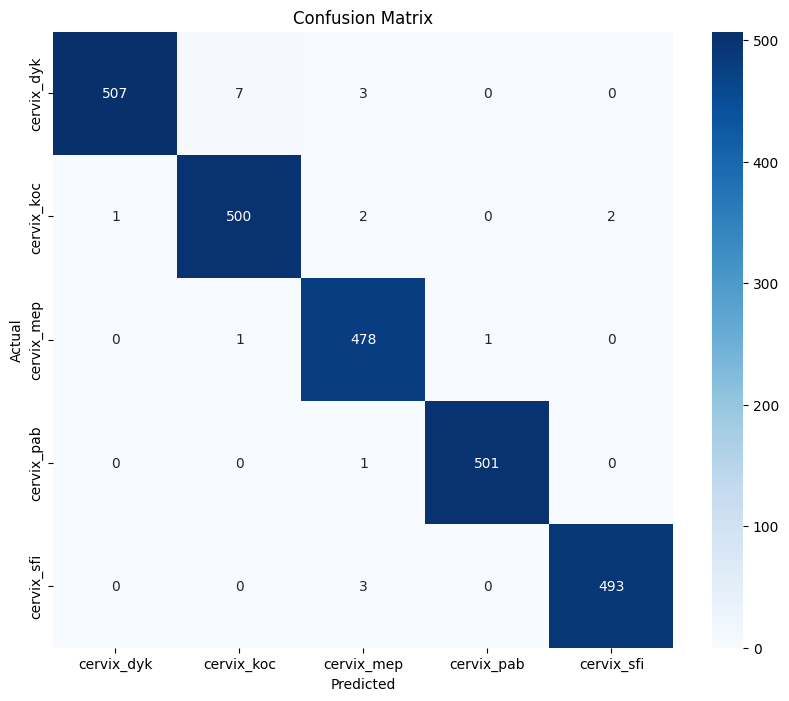

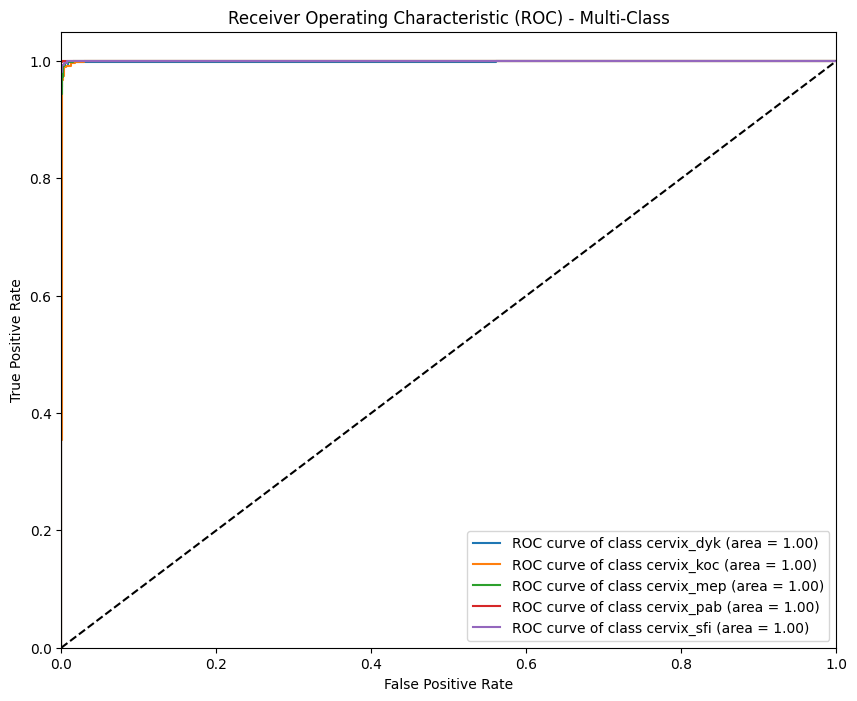


--- Area Under Curve (AUC) Scores ---
AUC for cervix_dyk: 0.9988
AUC for cervix_koc: 0.9995
AUC for cervix_mep: 0.9999
AUC for cervix_pab: 1.0000
AUC for cervix_sfi: 1.0000
Micro-average AUC: 0.9995

--- Generating SVM Learning Curve ---


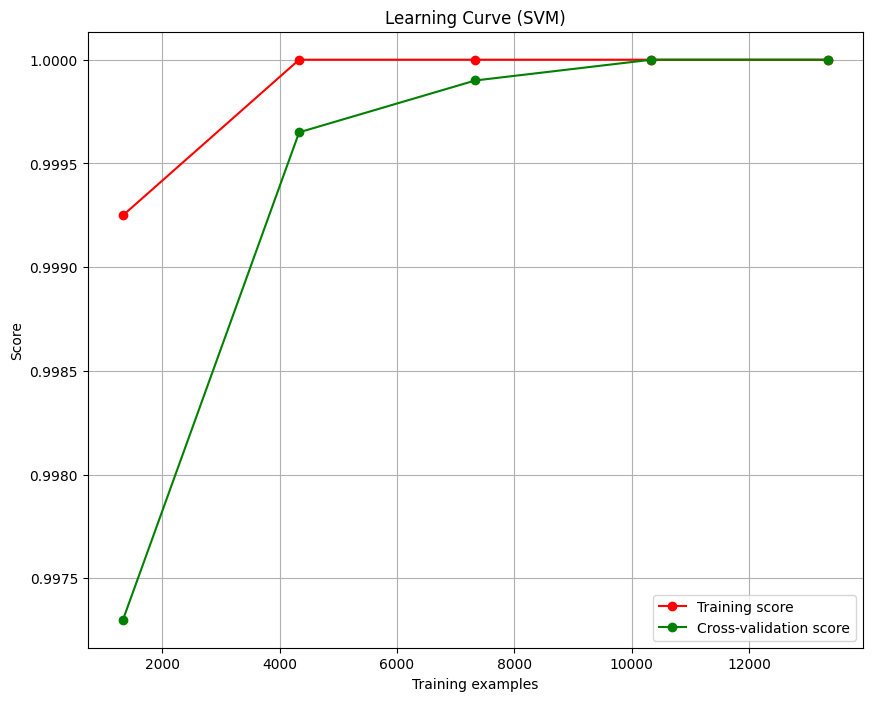

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

import joblib

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Data Loading and Preprocessing ---
# CORRECTED LOGIC: Since the dataset is not pre-split, we load the entire
# dataset from the specific cancer folder and then split it into train, validation, and test sets.

data_path = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer' # Path to the specific cancer type
train_data = None # Initialize to handle potential errors

if os.path.exists(data_path):
    try:
        # Image transforms
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Load the entire dataset from the specified path
        full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
        
        # Define split sizes (e.g., 80% train, 10% validation, 10% test)
        train_size = int(0.8 * len(full_dataset))
        val_size = int(0.1 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        # Perform the split
        train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])
        
        # Training Parameters
        batch_size = 32
        learning_rate = 0.001
        num_epochs = 20
        patience = 5 # Early stopping patience

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

        print("\n--- Dataset Information ---")
        print(f"Classes: {full_dataset.classes}")
        print(f"Total dataset size: {len(full_dataset)}")
        print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        train_data = None 
else:
    print(f"FATAL ERROR: The specified data path does not exist: {data_path}")
    print("Please verify your dataset's file structure on Kaggle.")


# --- 2. CNN Model Definition ---
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*32*32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))  # feature vector for SVM
        x = self.dropout(features)
        logits = self.fc2(x)
        return logits, features

# Only proceed if data was loaded successfully
if train_data:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Get the number of classes from the full dataset before the split
    model = CustomCNN(num_classes=len(full_dataset.classes)).to(device)
    print(f"\nUsing device: {device}")

    # --- 3. CNN Training ---
    print("\n--- Training the CNN Feature Extractor ---")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = np.inf
    counter = 0
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    cnn_training_start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss/len(train_loader))
        train_accs.append(correct/total)

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss/len(val_loader))
        val_accs.append(correct/total)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}% "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            counter = 0
            torch.save(model.state_dict(), "best_cnn.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

    cnn_training_end_time = time.time()
    cnn_training_time = cnn_training_end_time - cnn_training_start_time
    print(f"CNN Training time: {cnn_training_time:.2f} seconds")


    # --- 4. Feature Extraction ---
    print("\n--- Extracting Features from the CNN ---")
    model.load_state_dict(torch.load("best_cnn.pth"))
    model.eval()

    def extract_features(loader):
        features, labels = [], []
        # Get the underlying dataset from Subset object
        dataset = loader.dataset.dataset
        indices = loader.dataset.indices
        
        # Create a temporary loader to ensure order
        temp_loader = DataLoader(dataset, batch_size=loader.batch_size, sampler=torch.utils.data.SubsetRandomSampler(indices))

        with torch.no_grad():
            for imgs, lbls in temp_loader:
                imgs = imgs.to(device)
                _, feats = model(imgs)
                features.append(feats.cpu().numpy())
                labels.append(lbls.numpy())
        return np.concatenate(features), np.concatenate(labels)

    # Note: We need to recreate dataloaders for feature extraction to ensure correct mapping of subset indices
    X_train, y_train = extract_features(train_loader)
    X_val, y_val = extract_features(val_loader)
    X_test, y_test = extract_features(test_loader)
    
    print(f"Train features shape: {X_train.shape}, Test features shape: {X_test.shape}")


    # --- 5. SVM Training ---
    print("\n--- Training the SVM Classifier ---")
    svm_training_start_time = time.time()
    
    svm = SVC(probability=True, C=1.0, kernel='rbf', gamma='scale') # Example parameters
    svm.fit(X_train, y_train)

    svm_training_end_time = time.time()
    svm_training_time = svm_training_end_time - svm_training_start_time
    print(f"SVM training time: {svm_training_time:.2f} seconds")

    # Save SVM model
    joblib.dump(svm, "svm_model.pkl")


    # --- 6. Hybrid Model Evaluation ---
    print("\n--- Evaluating the Hybrid CNN-SVM Model ---")
    
    svm_testing_start_time = time.time()
    y_pred = svm.predict(X_test)
    y_prob = svm.predict_proba(X_test)
    svm_testing_end_time = time.time()
    svm_testing_time = svm_testing_end_time - svm_testing_start_time
    print(f"SVM testing time: {svm_testing_time:.2f} seconds")

    class_names = full_dataset.classes
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix and Class-wise Accuracy
    cm = confusion_matrix(y_test, y_pred)
    # Adding a small epsilon to avoid division by zero if a class has no samples in the test set
    class_wise_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-8)
    
    print("\n--- Class-wise Accuracy ---")
    for i, acc in enumerate(class_wise_accuracy):
        print(f"{class_names[i]}: {acc:.4f}")
        
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve and AUC
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
    plt.legend(loc="lower right")
    plt.show()
    
    print("\n--- Area Under Curve (AUC) Scores ---")
    for i in range(n_classes):
        print(f"AUC for {class_names[i]}: {roc_auc[i]:.4f}")
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    
    # --- 7. Learning Curve ---
    print("\n--- Generating SVM Learning Curve ---")
    train_sizes, train_scores, test_scores = learning_curve(
        SVC(probability=True, C=1.0, kernel='rbf', gamma='scale'), 
        X_train, y_train, cv=3, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 5)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 8))
    plt.grid()
    plt.title("Learning Curve (SVM)")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

